# Distribution of charities across location and time

### Introduction
This project uses data from http://opencharities.org/ which pulls data from the Charity Commission into a usable API. I downloaded a database of roughly 370,000 registered charities, including many that were now closed, on 21 December 2020. I've used geographical plotting and other graphing techniques to look at the distribution of charities across the UK and at how the distribution across regions and sectors has changed from the 1960s to the 2010s.

### Brief conclusions
Unsurprisingly, there is a significant weighting of charities towards the South-East, and London in particular. The scale of that concentration and its acceleration since the 1990s was more significant than expected. Even outside of London charities are heavily focused around populous areas. The types of activity, sector and beneficiary of charities doesn't greatly vary by region.

The list of charities has been filtered to remove those charities that have since closed so it is perhaps not surprising that there are more charities that have been established recently in each each sector and location but it does imply that many charities have a shelf life. There are some notable outliers that are discussed below.

In [1]:
#loads the relevant libraries
import geopandas as gpd
import numpy as np
import gdal
import matplotlib.pyplot as plt
from matplotlib import
import geoplot.crs as gcrs
import geoplot as gplt
import pgeocode
import pandas as pd
from shapely.geometry import Point 
import warnings

In [2]:
#loads the database of charities
charity_df = pd.read_csv("C:/Users/werho/Data Science/charity_clean.csv")
pcode = pgeocode.Nominatim(country="GB")

C:\Users\werho\.conda\envs\data_vis\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2,4,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#deletes records without a postcode
charity_df.dropna(subset=['post_code'], inplace = True)
#removes the charities that have been removed from the charity register so are inactive
charity_df = charity_df[charity_df['date_removed'].isnull()]

In [4]:
print(charity_df.count())

Unnamed: 0                     138020
title                          138020
charity_number                 138020
activities                     104722
contact_name                    13855
address                        138020
website                         75663
telephone                      136154
date_registered                138019
date_removed                        0
accounts_date                   99963
spending                           91
income                             91
opencharities_url              138020
twitter_account_name             9123
facebook_account_name            6144
youtube_account_name             3345
feed_url                         6151
charity_classification_uids    137584
last_checked                   138020
created_at                     138020
updated_at                     138020
post_code                      138020
dtype: int64


In [5]:
#creates a function to convert a postcode into longitude and latitude coordinates
def getlonglat(post_code):
        return pcode.query_postal_code(post_code)['longitude'], pcode.query_postal_code(post_code)['latitude']        
#applies the function to all records in the database
charity_df['longlat'] = charity_df['post_code'].apply(getlonglat)

In [6]:
#prints a snapshot of the new column
print(charity_df['longlat'])
#creates a geometry column for use in geographic plotting
charity_df['geometry'] = [Point(xy) for xy in zip(charity_df['longlat'])]
#saves the updated database to a new spreadsheet
charity_df.to_csv('charity_map_geometry.csv')

0                               (-2.4333, 52.6333)
2                               (-2.0981, 57.1437)
8                   (-0.44616666666666666, 53.761)
9                               (-2.0981, 57.1437)
10                  (-2.1999307692307712, 57.3681)
                            ...                   
371410    (-3.4110753623188352, 51.94300000000001)
371411              (-1.2355166666666666, 51.6013)
371412             (-0.25975000000000004, 51.3495)
371413               (-0.4508083333333332, 52.607)
371414              (-0.2569199999999999, 51.5961)
Name: longlat, Length: 138020, dtype: object


In [7]:
#snapshot of the geometry data
charity_df['geometry'].head()

0                POINT (-2.4333 52.6333)
2                POINT (-2.0981 57.1437)
8     POINT (-0.4461666666666667 53.761)
9                POINT (-2.0981 57.1437)
10    POINT (-2.199930769230771 57.3681)
Name: geometry, dtype: object

In [8]:
#puts the uk outline map and charity data into GeoDataFrames with matching location data and adds a location for the labels
gdf = gpd.read_file('C:/Users/werho/Data Science/Regions__December_2017__Boundaries-shp/Regions__December_2017__Boundaries.shp')
#shapefile sourced from Office for National Statistics Open Geography Portal on 21/12/20.
#source: https://geoportal.statistics.gov.uk/datasets/4fcca2a47fed4bfaa1793015a18537ac_4
#https://geoportal.statistics.gov.uk/datasets/4fcca2a47fed4bfaa1793015a18537ac_4
gdf2 = gpd.GeoDataFrame(charity_df)
gdf = gdf.to_crs('epsg:4326')
gdf['label'] = gdf['geometry'].apply(lambda x: x.representative_point())

In [9]:
#create a GeoDataFrame of the key cities on the map
cities = pd.read_csv("C:/Users/werho/Data Science/gb_cities_longlat.csv") #open csv
cities['city_name'] = cities['city'] #create a copy of the 'city' column
cities.set_index("city", inplace=True) #set the city column to the index
cities = cities.loc[['London','Manchester','Bristol','Leeds','Nottingham','Newcastle']] #filter the list to specific cities
cities['geometry'] = [Point(xy) for xy in zip(cities['lng'], cities['lat'])] #create a geometry column for plotting
gdf3 = gpd.GeoDataFrame(cities) #create a GeoDataFrame for plotting
gdf3 = gdf3.set_crs('epsg:4326') #set the referencing system

In [10]:
print(gdf3['geometry']) #check the geometry data

city
London        POINT (-0.12750 51.50720)
Manchester    POINT (-2.24530 53.47940)
Bristol       POINT (-2.58330 51.45000)
Leeds         POINT (-1.54920 53.79970)
Nottingham    POINT (-1.15000 52.95000)
Newcastle     POINT (-1.65780 55.00770)
Name: geometry, dtype: geometry


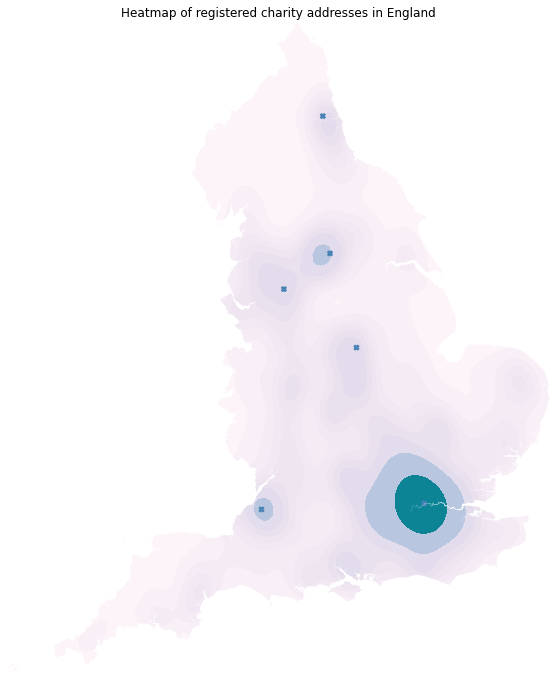

<Figure size 432x288 with 0 Axes>

In [519]:
#draws a heatmap of the charities based on their registered addresses and overlays points for some significant cities
ax = gplt.kdeplot(gdf2, 
                  cmap='PuBuGn',
                  clip=gdf, 
                  shade=True, 
                  shade_lowest=True, 
                  figsize=(12,12), 
                  projection=gplt.crs.Mercator(),
                  extent=gdf.total_bounds)
gplt.pointplot(gdf3,
                   ax=ax, 
                   zorder=2,
                   extent=gdf.total_bounds,
                   marker='X')
plt.title("Heatmap of registered charity addresses in England")
plt.show()
plt.savefig("nationwide_heatmap.png")

## Spread of charities across England

The heat map shows an unsurprisingly heavy focus on London for the registered location of charities but the heaviness of the weighting is stark. While many London-based charities will have a national or international focus, many of their staff, even more so in senior positions, will be London-based and would have to work much harder to understand the needs and experiences of those outside London and South East. Of course, this map doesn't show regional offices or even necessarily represent the location of head offices but it is likely to be an accurate representation of the distribution of employees overall.

The other warm spots outside of London represent obvious large urban centres like Manchester and Liverpool, but also surprisingly there are significant spots at Leeds, Bristol, Nottingham and Newcastle for reasons that are not immediately obvious.


In [12]:
#creates an empty column to store the count of charities in each region
gdf['charity_count'] = 0

In [13]:
#counts the number of charities that fall within each area polygon
for row in gdf.index:
    count  = gdf2['title'][gdf2['geometry'].within(gdf.loc[row]['geometry'])].count()
    gdf.at[row, 'charity_count'] = count   
print(gdf['charity_count'])

0     4926
1    10895
2     9596
3    10854
4     9760
5    18684
6    17012
7    28326
8    18609
Name: charity_count, dtype: int64


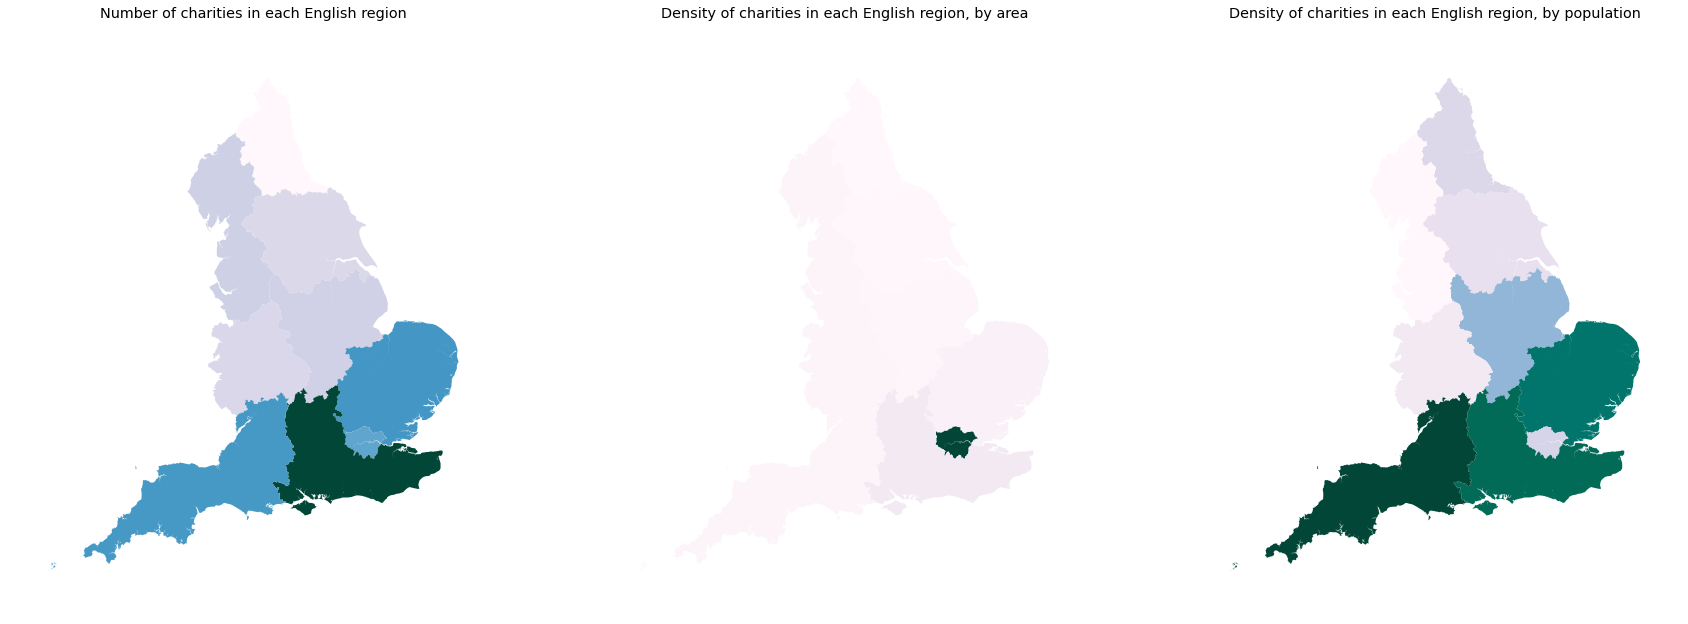

In [517]:
fig = plt.figure(figsize=(30,15))
ax1 = plt.subplot(131, projection=gplt.crs.Mercator())
ax2 = plt.subplot(132, projection=gplt.crs.Mercator())
ax3 = plt.subplot(133, projection=gplt.crs.Mercator())

#plots the charity counts by area.
gplt.choropleth(gdf,
                hue='charity_count', 
                cmap='PuBuGn', 
                ax=ax1)
ax1.set_title("Number of charities in each English region", fontsize='x-large')

#detects the density of charities by area in each region
gdf['density'] = gdf['charity_count'] / gdf['st_areasha']

#plots the density on a colour map of the regions
gplt.choropleth(gdf, 
                hue='density', 
                cmap='PuBuGn', 
                ax=ax2)
ax2.set_title("Density of charities in each English region, by area", fontsize='x-large')

#Adds population in millions to the regions.
#Source: https://www.statista.com/statistics/294681/population-england-united-kingdom-uk-regional/
gdf['population'] = [2.67, 7.34, 5.5, 4.84, 5.93, 6.24, 8.96, 9.18, 5.62]

#counts the density of charities by population in each region
gdf['popn_density'] = gdf['charity_count'] / gdf['population']

#plots the density of charities by population on a colour map of the regions
gplt.choropleth(gdf, 
                hue='popn_density', 
                cmap='PuBuGn',
                ax=ax3)
ax3.set_title("Density of charities in each English region, by population", fontsize='x-large')
plt.savefig("charity_popn_density_by_region.png")
plt.show()

### Whichever way you look, the South dominates

The heatmap doesn't tell the whole picture. When we look at the the number of charities in any given region it's the South East that comes out on top but we still see a stark divide between the South and East and the rest of the country. When we look at the number of charities compared to the area of each region, London once again dominates, almost completely whiting out the rest of the map. Finally, when we look at the number of charities compared the population of each region, it is the South-West that dominates but once again the contrast between the South and East, and Midlands and North is stark.

In [15]:
#puts the date registered in datetime format
gdf2['date_registered'] = pd.to_datetime(gdf2['date_registered'])
#removes rows where there is no registration date
gdf2['date_registered'] = gdf2['date_registered'][gdf2['date_registered'].notnull()]
#puts the year of registration into a new column
gdf2['year'] = pd.DatetimeIndex(gdf2['date_registered']).year
#calculates the decade that charity was registered
gdf2['decade'] = (gdf2['year']//10)*10
#count the number of charities registered in each decade
print(gdf2['decade'].value_counts())
#group the counts by the number of charities registered in each decade 
decade_groups = gdf2.groupby('decade').count()
#rename the column containing the region names for easier access
gdf.rename(columns={'rgn17nm' : 'region'}, inplace=True)

2010.0    36801
1990.0    27539
2000.0    27217
1960.0    21234
1980.0    12544
1970.0     9780
2020.0     2904
Name: decade, dtype: int64


In [ ]:
#creates a new dataframe with the number of new charity registrations in each decade by region and adds a region column to the existing list of charities
charity_region_df = pd.DataFrame()
region_decade_df = pd.DataFrame()
for row in gdf.index: #iterates through the list of regions
    temp_df = gdf2[gdf2['geometry'].within(gdf.loc[row]['geometry'])] #creates a temp dataframe with the just the charities in the current region
    temp_df['region'] = gdf.loc[row]['region'] #adds a column with the region name to that dataframe
    charity_region_df = charity_region_df.append(temp_df) #adds the new dataframe to the full list of charities
    grouped = temp_df.groupby('decade', as_index = False).count() #counts the number of charities in the region registered in each decade
    grouped['region'] = gdf.loc[row]['region'] #adds a column with the region name
    region_decade_df = region_decade_df.append(grouped) #adds these counts the dataframe of charity registrations by region and decade

In [ ]:
#rename the year column to count new charities
region_decade_df.rename(columns={"year" : "new_charities"}, inplace=True)
#removes unnecessary columns from the dataframe
region_decade_df = region_decade_df[['region', 'decade', 'new_charities']].copy()
#pivots the frame so that the index is the decade with columns for each region
region_decade_pivot_df = region_decade_df.pivot(index="decade", columns="region", values="new_charities")
region_decade_pivot_df = region_decade_pivot_df.sort_values(by =2010.0, axis=1)

In [ ]:
region_decade_pivot_df.to_csv('charities_established_decade.csv')

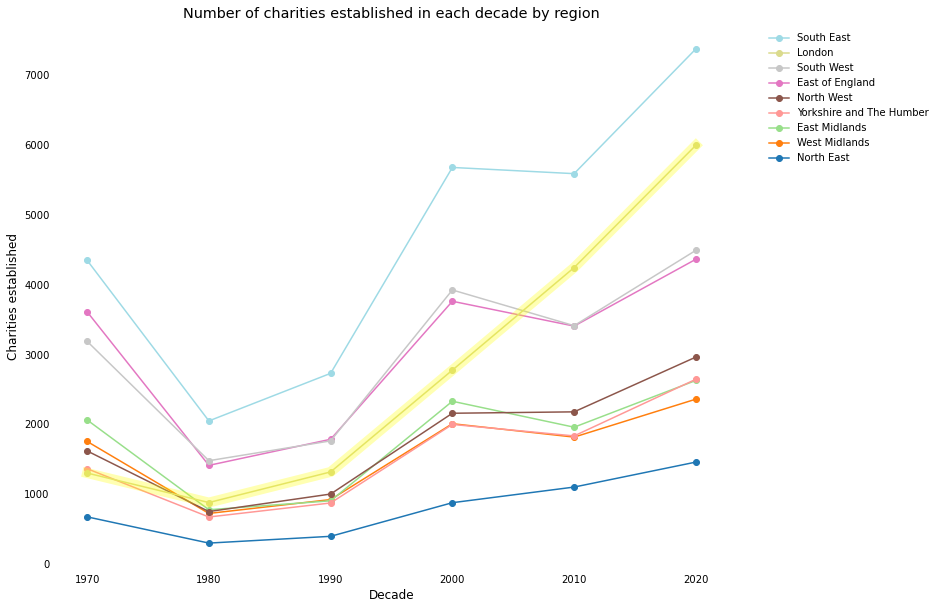

In [507]:
# plots the number of new charities created in each region in each decade
ax = region_decade_pivot_df.iloc[-7:-1,:].plot(figsize=(12,10), cmap='tab20', marker='o')
plt.plot(region_decade_pivot_df.iloc[-7:-1,-2], color='Yellow', lw=10, alpha=0.3)
ax.axes.set_ylabel("Charities established", fontsize='large')
ax.axes.set_xlabel("Decade", fontsize='large')
ax.tick_params(bottom=False, left=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks(np.arange(0, 7500, step=1000))
ax.set_xticklabels(['1960','1970', '1980', '1990', '2000', '2010', '2020'])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], region_decade_pivot_df.columns[::-1], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.set_title("Number of charities established in each decade by region", fontsize='x-large')
plt.savefig("charities_established_decade_region.png")

### Changes elsewhere remain steady while London and the South East increasingly dominate

*This chart shows just currently operating charities*

The Charities Act 1960 saw the introduction of a charity register hence the large number of registrations in that decade and from the 1970s onward every decade has seen a rise in the number of new charities compared to the last. The differences between the regions have remained largely static with a slight widening of the gap between the Midlands and North, and the South. The exception is London which has seen a significant increase of its share since the 1990s as highlighted on the chart. 

 I'm not in a position to present a detailed answer as to why these two trends might have come about, but the charity sector is not immune to the trend of skilled and graduate-level jobs gravitating towards London and this could be a vicious cycle whereby charities feel that they have to be in the South to attract the best talent, drawing more talent to London and so-on.The general increase in new charities could be down to increased need, increased philanthropy, or some more mundane factor like more funding opportunities only being available to registered charities.


In [19]:
print(gdf['region'].value_counts())

West Midlands               1
East of England             1
South East                  1
Yorkshire and The Humber    1
London                      1
North East                  1
South West                  1
East Midlands               1
North West                  1
Name: region, dtype: int64


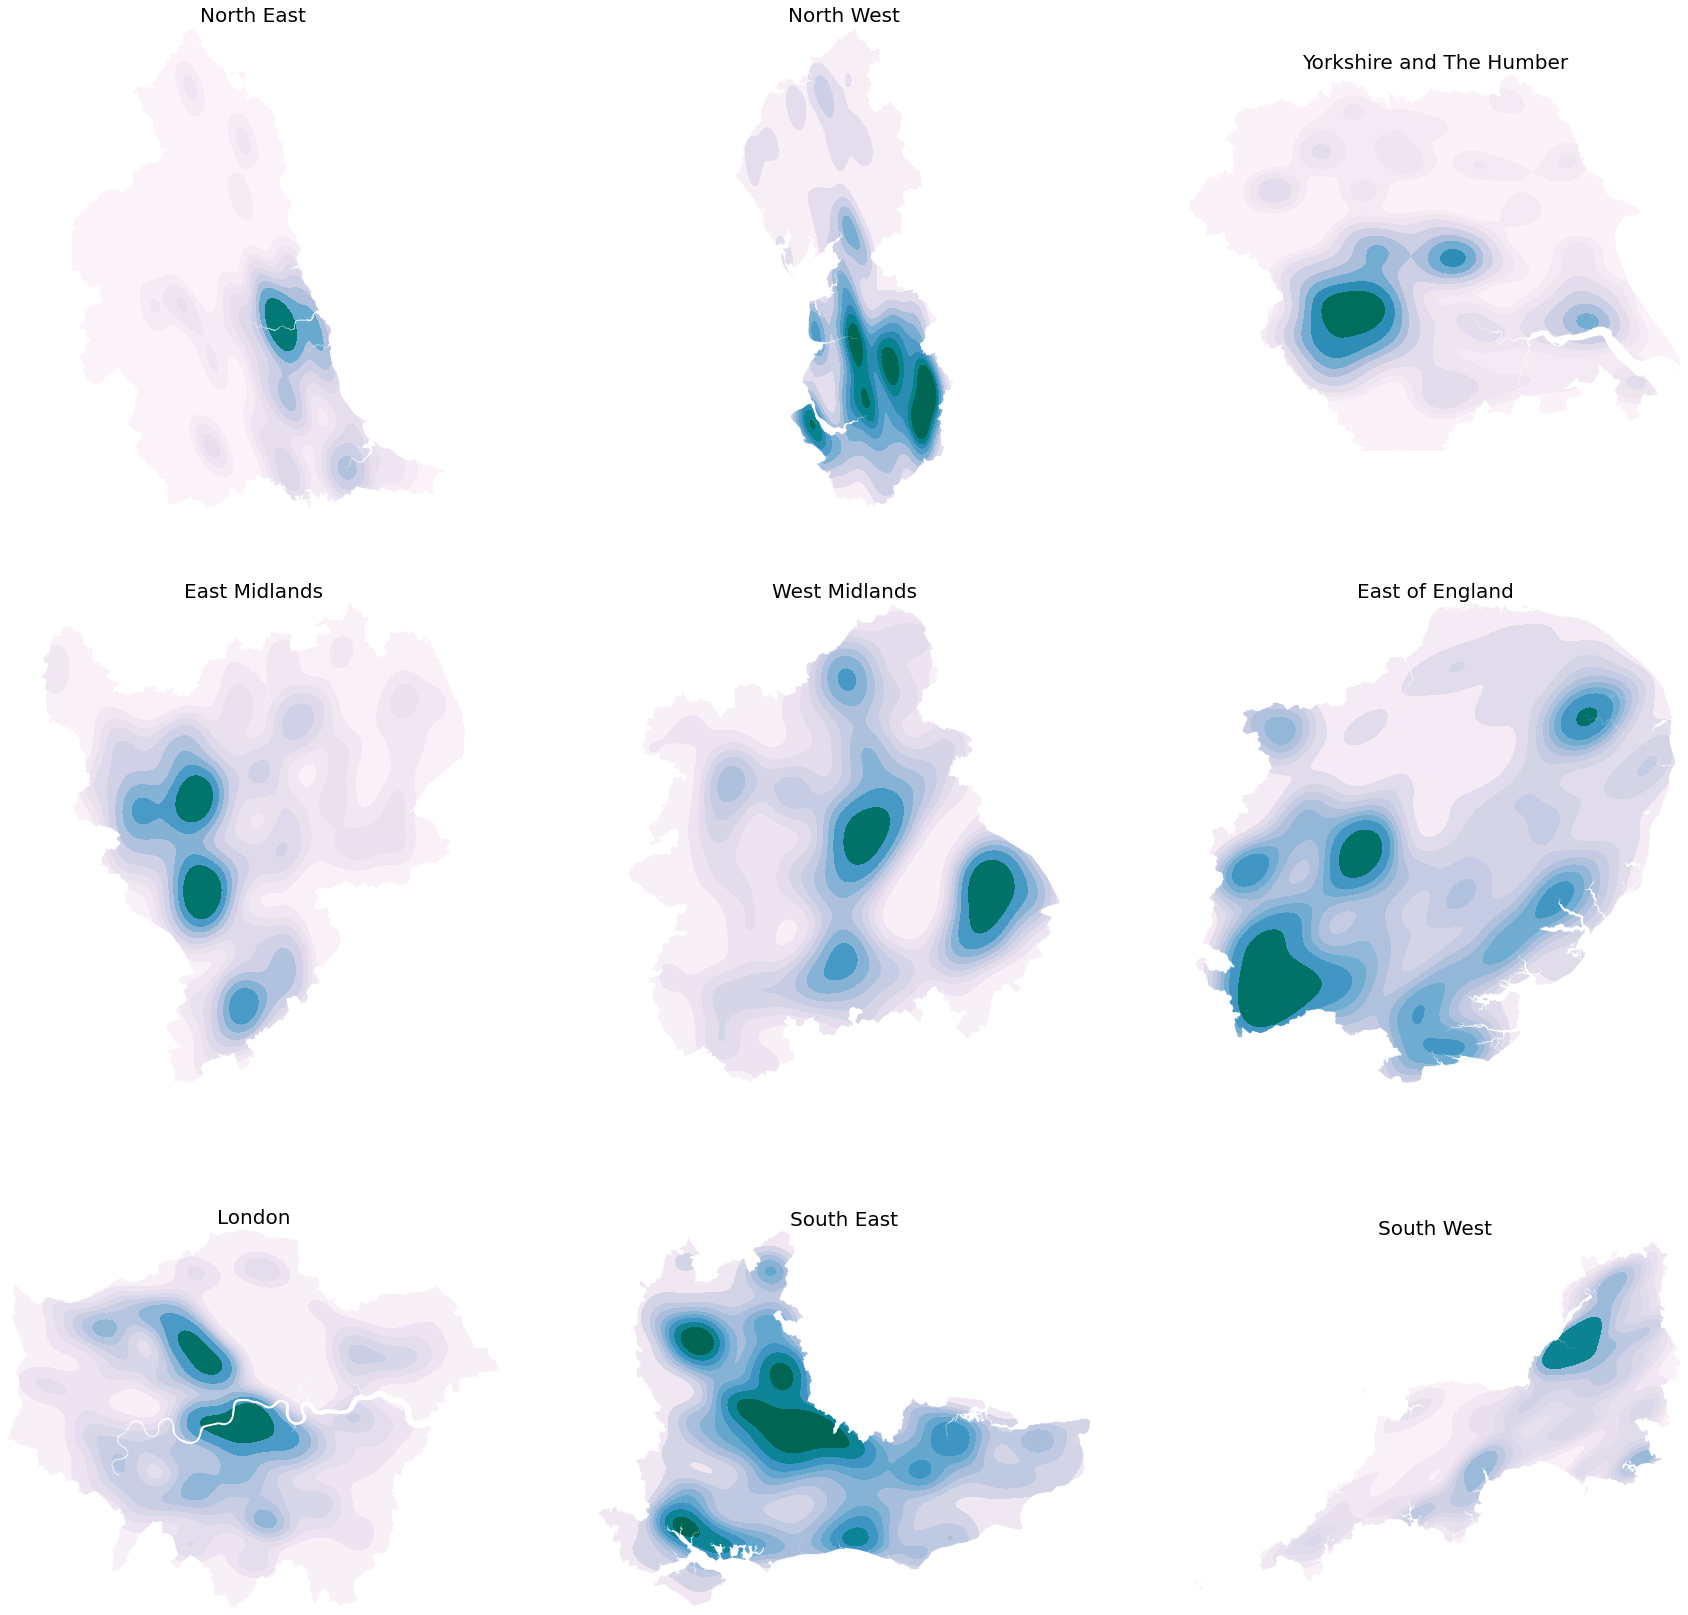

In [518]:
#draws a heatmap of the charities based on their registered addresses and overlays points for some significant cities
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
proj = gplt.crs.Mercator()
fig,axs = plt.subplots(3,3, figsize=(30,30), subplot_kw={'projection': proj})
x = [0,0,0,1,1,1,2,2,2]
y = [0,1,2,0,1,2,0,1,2]
i = -1
#iterates through the regions drawing a new map for each
for region in gdf['region']:
    query = "region == \""+region+"\""
    clip = gdf.query(query)
    extent = gdf.query(query).total_bounds
    i+=1
    gplt.kdeplot(charity_region_df[charity_region_df["region"] == region],   
                      cmap='PuBuGn',
                      clip=clip, 
                      shade=True, 
                      shade_lowest=True, 
                      extent=extent,
                      ax = axs[x[i],y[i]])
    axs[x[i],y[i]].set_title(region, fontsize=20)
plt.savefig("heat_maps_by_region.png")
plt.show()

### All around the country charities are largely located in high-population urban areas

Somewhat predictably, even within individual regions, charities are registered mainly where there are large numbers of people. While this is to be expected and almost certainly overlays with concentrations of other activities, there do appear to be relative deserts outside of those areas, leaving those in rural areas potentially underserved by charitable services.

***Comment on the process of generating the data:***
*The original spreadsheet of charity data included a column 'charity_classification_uids' which contains a series of three-digit codes
which represent different classifications of charitable activity, charity and sector. These codes were not accompanied by any dictionary
of definitions. I was able to infer the definitions by making manual comparisons to the data held on the Charity Commission website.
This is not perfect because some of the codes are recorded as 000 and therefore can't be automatically detected.
Once I had the definitions for each of the codes I was able to translate them into a format that could be compared to the orignal
spreadsheet to review the distribution of types of charity.*

In [265]:
#This code reads the spreadsheet of code definitions and cleans it to make it easier to use within Python
commission_codes = pd.read_csv("charity_commission_codes.csv")
commission_codes.columns = commission_codes.columns.str.lower()
columns1 = ['beneficiary_name', 'sector_name', 'services_name']
for column in columns1:
    commission_codes[column] = commission_codes[column].str.lower().str.replace(" ","_").str.replace("\/","_")
columns2 = ['beneficiary_code', 'sector_code', 'services_code']
for column in columns2:
    commission_codes[column] = commission_codes[column].fillna(0.0).astype(int)

In [95]:
#converts the list of codes in the original spreadsheet into a string for comparison.
charity_region_df['charity_classification_uids'] = charity_region_df['charity_classification_uids'].astype(str)

In [411]:
#creates an empty dataframe to store the new counts
region_decade_sector = pd.DataFrame()
sectors_by_region_df = pd.DataFrame()
#iterates through the list of sectors to count the number of charities operating in each sector in each region
for row in commission_codes.index:
    #creates a name for the new column
    col_name = commission_codes.loc[row]['sector_name']
    #creates the search term
    search = commission_codes.loc[row]['sector_code']
    #creates a temp dataframe containing the charity region where the charity matches the current sector code
    sector_count = charity_region_df['region'][charity_region_df['charity_classification_uids'].str.contains(str(search))]
    #groups the new dataframe by region and counts the sum of charities in the sector in each region
    sector_count_groups = sector_count.groupby(sector_count).count()
    #fills a column in the new dataframe with current sector
    sector_count_groups['sector_name'] = col_name
    #adds the counts for this sector to the wider dataframe
    sectors_by_region_df = sectors_by_region_df.append(sector_count_groups)

sectors_by_region_df.reset_index(inplace=True) #fixes the index
sectors_by_region_df = sectors_by_region_df.drop(columns='index') #deletes the old index column
sectors_by_region_df = sectors_by_region_df.set_index('sector_name') #makes the sector name the index
region_decade_sector = pd.concat([sectors_by_region_df, region_decade_pivot_df]) #adds the new dataframe to the old one

In [412]:
#this block creates a new row which is the sum of all the charities in each sector
sums = region_decade_sector.iloc[:17,:].sum()
region_decade_sector.loc[len(region_decade_sector)] = sums
region_decade_sector = region_decade_sector.rename({24:'sec_total_charities'})

In [413]:
#creates a new row for each of the sectors to count the percentage of the total charities in that region in that sector.
for sector in region_decade_sector.index[:17]:
    name = sector+'_pc'
    region_decade_sector.loc[name] = round((region_decade_sector.loc[sector]/region_decade_sector.loc['sec_total_charities']*100),1)

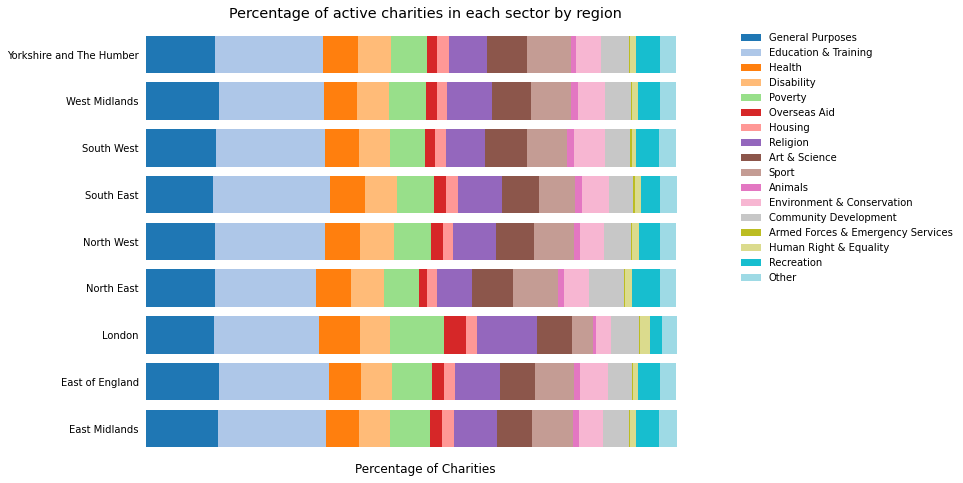

In [426]:
legends = ['General Purposes', 'Education & Training', 'Health', 'Disability', 'Poverty', 
           'Overseas Aid', 'Housing', 'Religion', 'Art & Science', 'Sport', 'Animals',
          'Environment & Conservation', 'Community Development', 'Armed Forces & Emergency Services',
          'Human Right & Equality', 'Recreation', 'Other']
#plots the percentages on a stacked bar chart
ax = region_decade_sector.iloc[-17:,:].transpose().plot(kind='barh',
                                                  stacked=True,
                                                  cmap='tab20',
                                                  figsize=(10,8),
                                                  sort_columns=True,
                                                  width=0.8)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, legends, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.axes.set_xlabel("Percentage of Charities", fontsize='large')
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title("Percentage of active charities in each sector by region", fontsize='x-large')
plt.savefig("charities_region_sector.png")
plt.show()


### No siginificant differences in the distribution of charity sectors between regions

I was surprised to see that there are no big differences in the distribution of sectors that charities operate in across the different regions, beyond a slight over-repcharity_classification_uidsresentation religious and poverty focused charities in London. Given the differing needs across the country and what I assume is a concentration of charities in London who's work is internationally focussed, I expected there to be greater distribution. 

In [415]:
#repeats the above code to review the distribution of beneficiary types
#creates an empty dataframe to store the new counts
beneficiary_by_region_df = pd.DataFrame()
#iterates through the list of sectors to count the number of charities with each beneficiary in each region
for row in commission_codes.index[:7]:
    #creates a name for the new column
    col_name = "ben_"+str(commission_codes.loc[row]['beneficiary_name'])
    #creates the search term
    search = commission_codes.loc[row]['beneficiary_code']
    #creates a temp dataframe containing the charity region where the charity matches the current sector code
    beneficiary_count = charity_region_df['region'][charity_region_df['charity_classification_uids'].str.contains(str(search))]
    #groups the new dataframe by region and counts the sum of charities in the sector in each region
    beneficiary_count_groups = beneficiary_count.groupby(beneficiary_count).count()
    #fills a column in the new dataframe with current sector
    beneficiary_count_groups['beneficiary_name'] = col_name
    #adds the counts for this sector to the wider dataframe
    beneficiary_by_region_df = beneficiary_by_region_df.append(beneficiary_count_groups)

beneficiary_by_region_df.reset_index(inplace=True) #fixes the index
beneficiary_by_region_df = beneficiary_by_region_df.drop(columns='index') #deletes the old index column
beneficiary_by_region_df = beneficiary_by_region_df.set_index('beneficiary_name') #makes the sector name the index
region_decade_codes = pd.concat([beneficiary_by_region_df, region_decade_sector]) #adds the new dataframe to the old one

In [416]:
#this block creates a new row which is the sum of all the charities with those beneficiaries
sums = region_decade_codes.iloc[:7,:].sum()
row_num = len(region_decade_codes)
region_decade_codes.loc[row_num] = sums
region_decade_codes = region_decade_codes.rename({row_num:'ben_total_charities'})

In [417]:
#creates a new row for each of the sectors to count the percentage of the total charities in that region with those beneficiaries
for ben in region_decade_codes.index[:7]:
    name = ben+'_pc'
    region_decade_codes.loc[name] = round((region_decade_codes.loc[ben]/region_decade_codes.loc['ben_total_charities']*100),1)

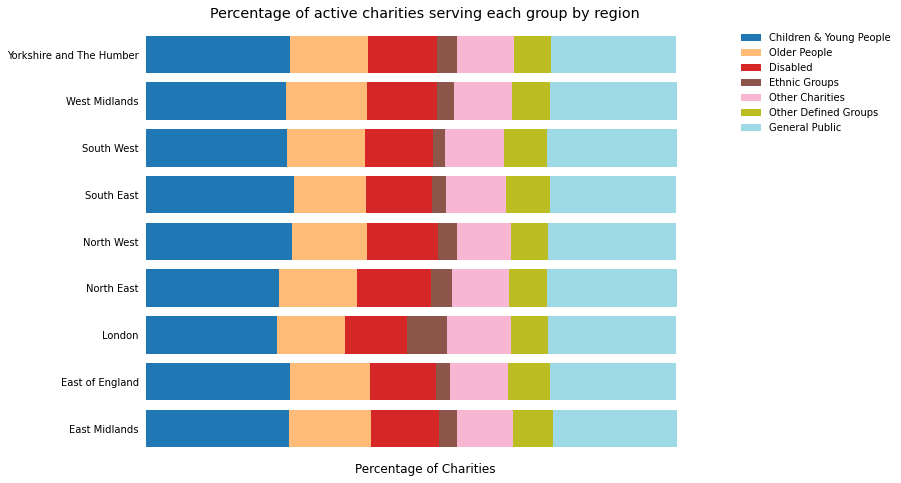

In [418]:
legends = ['Children & Young People', 'Older People', 'Disabled', 
           'Ethnic Groups', 'Other Charities', 'Other Defined Groups', 'General Public']
#plots the percentages on a stacked bar chart
ax = region_decade_codes.iloc[-7:,:].transpose().plot(kind='barh',
                                                  stacked=True,
                                                  cmap='tab20',
                                                  figsize=(10,8),
                                                  sort_columns=True,
                                                  width=0.8)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, legends, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.axes.set_xlabel("Percentage of Charities", fontsize='large')
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title("Percentage of active charities serving each group by region", fontsize='x-large')
plt.savefig("charities_region_beneficiary.png")
plt.show()

In [419]:
#repeats the above code to review the distribution of types of services
#creates an empty dataframe to store the new counts
services_by_region_df = pd.DataFrame()
#iterates through the list of sectors to count the number of charities with each beneficiary in each region
for row in commission_codes.index[:10]:
    #creates a name for the new column
    col_name = "ben_"+str(commission_codes.loc[row]['services_name'])
    #creates the search term
    search = commission_codes.loc[row]['services_code']
    #creates a temp dataframe containing the charity region where the charity matches the current sector code
    services_count = charity_region_df['region'][charity_region_df['charity_classification_uids'].str.contains(str(search))]
    #groups the new dataframe by region and counts the sum of charities in the sector in each region
    services_count_groups = services_count.groupby(services_count).count()
    #fills a column in the new dataframe with current sector
    services_count_groups['services_name'] = col_name
    #adds the counts for this sector to the wider dataframe
    services_by_region_df = services_by_region_df.append(services_count_groups)

services_by_region_df.reset_index(inplace=True) #fixes the index
services_by_region_df = services_by_region_df.drop(columns='index') #deletes the old index column
services_by_region_df = services_by_region_df.set_index('services_name') #makes the sector name the index
region_decade_codes = pd.concat([services_by_region_df, region_decade_codes]) #adds the new dataframe to the old one

In [420]:
#this block creates a new row which is the sum of all the charities with those beneficiaries
sums = region_decade_codes.iloc[:10,:].sum()
row_num = len(region_decade_codes)
region_decade_codes.loc[row_num] = sums
region_decade_codes = region_decade_codes.rename({row_num:'ser_total_charities'})

In [421]:
#creates a new row for each of the sectors to count the percentage of the total charities in that region with those beneficiaries
for ser in region_decade_codes.index[:10]:
    name = ser+'_pc'
    region_decade_codes.loc[name] = round((region_decade_codes.loc[ser]/region_decade_codes.loc['ser_total_charities']*100),1)

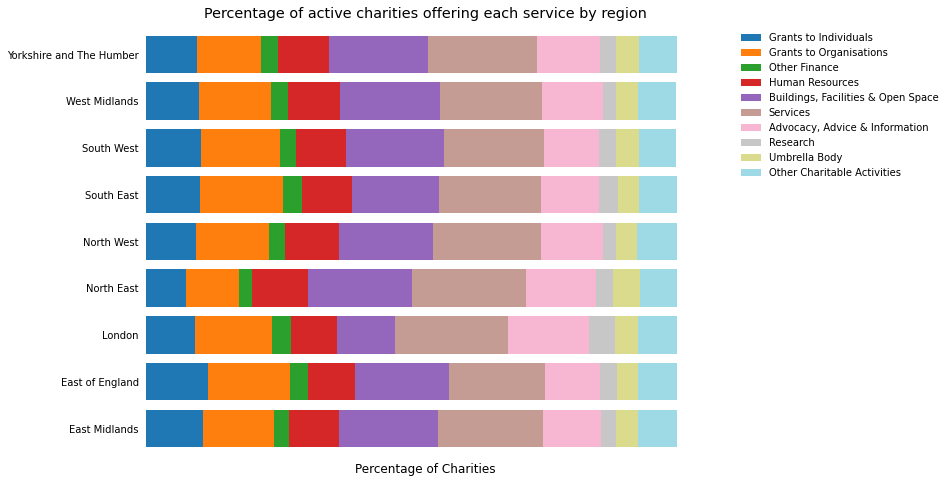

In [427]:
legends = ['Grants to Individuals', 'Grants to Organisations', 'Other Finance', 'Human Resources', 
           'Buildings, Facilities & Open Space', 'Services', 'Advocacy, Advice & Information',
           'Research', 'Umbrella Body', 'Other Charitable Activities']
#plots the percentages on a stacked bar chart
ax = region_decade_codes.iloc[-10:,:].transpose().plot(kind='barh',
                                                  stacked=True,
                                                  cmap='tab20',
                                                  figsize=(10,8),
                                                  sort_columns=True,
                                                  width=0.8)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, legends, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.axes.set_xlabel("Percentage of Charities", fontsize='large')
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title("Percentage of active charities offering each service by region", fontsize='x-large')
plt.savefig("charities_region_services.png")
plt.show()

### Beneficiaries and services don't vary much by region

The beneficiaries across regions are perhaps even more uniform than the sectors, with the exception of London which has more charities working with specific ethnicity, which is unsurprising given the cities metropolitan nature.

Types of service offered vary a little more but are still pretty uniform with the notable exceptions of the North East which has fewer charities offering grants and London which has fewer charities operating physical spaces but has more charities offering advocacy and advice, and doing research, perhaps reflecting the greater professionalisation of charities in the capital.

In [424]:
# This cell creates a new dataframe to count the number of charities created in each sector in each decade
charity_decade_sector_df = pd.DataFrame()
temp_df = pd.DataFrame()
for row in commission_codes.index: #iterates through the list of sectors
    #creates a name for the new column
    name = commission_codes.loc[row]['sector_name']
    #creates the search term
    search = commission_codes.loc[row]['sector_code']
    #puts the relevant charities into a temp frame where they match the current search code
    temp_df = charity_region_df[charity_region_df['charity_classification_uids'].str.contains(str(search))] 
    grouped = temp_df.groupby('decade').count() 
    grouped['sector'] = name 
    charity_decade_sector_df = charity_decade_sector_df.append(grouped) 

#cleans up the dataframe to make it clearer for visualisation
charity_decade_sector_df.rename(columns={"year" : "new_charities"}, inplace=True)
charity_decade_sector_df = charity_decade_sector_df[['new_charities', 'sector']]
charity_decade_sector_df.reset_index(inplace=True)
charity_decade_sector_df = charity_decade_sector_df.pivot(index="decade", columns="sector", values="new_charities")
charity_decade_sector_df = charity_decade_sector_df.sort_values(by=2010.0, axis=1)

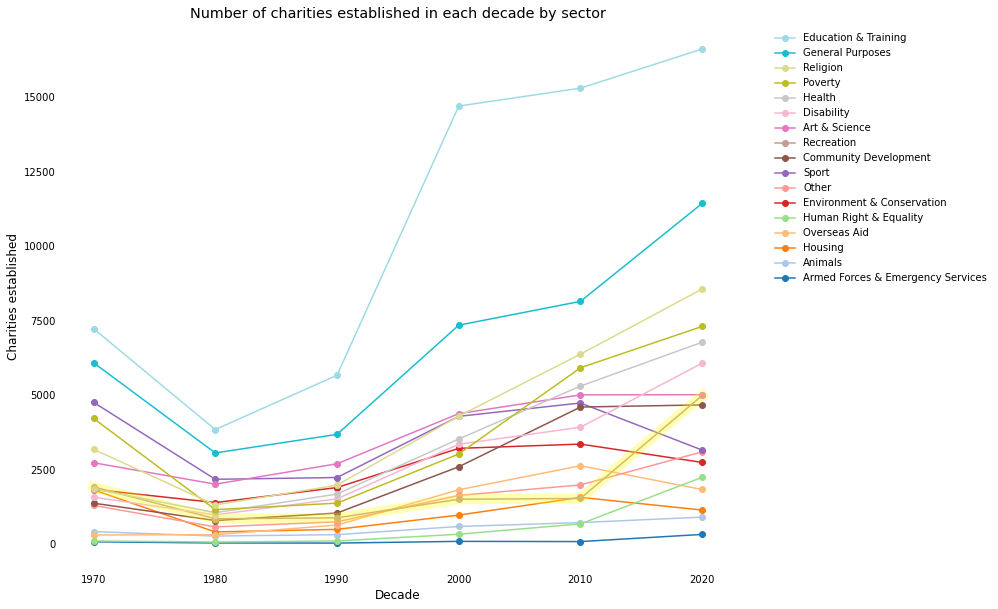

In [496]:
legends = ['Armed Forces & Emergency Services','Animals','Housing', 'Overseas Aid', 'Human Right & Equality',
           'Environment & Conservation', 'Other', 'Sport', 'Community Development', 'Recreation', 
           'Art & Science', 'Disability', 'Health',  'Poverty', 'Religion', 'General Purposes', 'Education & Training']
# plots the number of new charities created in each sector in each decade
ax = charity_decade_sector_df.iloc[-7:-1,:].plot(figsize=(12,10), cmap='tab20', marker='o')
plt.plot(charity_decade_sector_df.iloc[:-1,9], color='Yellow', lw=10, alpha=0.3)
ax.axes.set_ylabel("Charities established", fontsize='large')
ax.axes.set_xlabel("Decade", fontsize='large')
ax.tick_params(bottom=False, left=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks(np.arange(0, 17500, step=2500))
ax.set_xticklabels(['1960','1970', '1980', '1990', '2000', '2010', '2020'])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], legends[::-1], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.set_title("Number of charities established in each decade by sector", fontsize='x-large')
plt.savefig("charities_established_decade_sector.png")

In [437]:
#This cell creates a new dataframe that counts the number of charities created in each decade in each beneficiary group
charity_decade_beneficiary_df = pd.DataFrame()
temp_df = pd.DataFrame()
for row in commission_codes.index[:7]: #iterates through the list of beneficiary codes
    #creates a name for the new column
    name = commission_codes.loc[row]['beneficiary_name']
    #creates the search term
    search = commission_codes.loc[row]['beneficiary_code']
    #puts the relevant charities into a temp frame where they match the current search code
    temp_df = charity_region_df[charity_region_df['charity_classification_uids'].str.contains(str(search))] 
    grouped = temp_df.groupby('decade').count() 
    grouped['beneficiary'] = name 
    charity_decade_beneficiary_df = charity_decade_beneficiary_df.append(grouped) 

#cleans up the dataframe to make it clearer for visualisation
charity_decade_beneficiary_df.rename(columns={"year" : "new_charities"}, inplace=True)
charity_decade_beneficiary_df = charity_decade_beneficiary_df[['new_charities', 'beneficiary']]
charity_decade_beneficiary_df.reset_index(inplace=True)
charity_decade_beneficiary_df = charity_decade_beneficiary_df.pivot(index="decade", columns="beneficiary", values="new_charities")
charity_decade_beneficiary_df = charity_decade_beneficiary_df.sort_values(by=2010.0, axis=1)

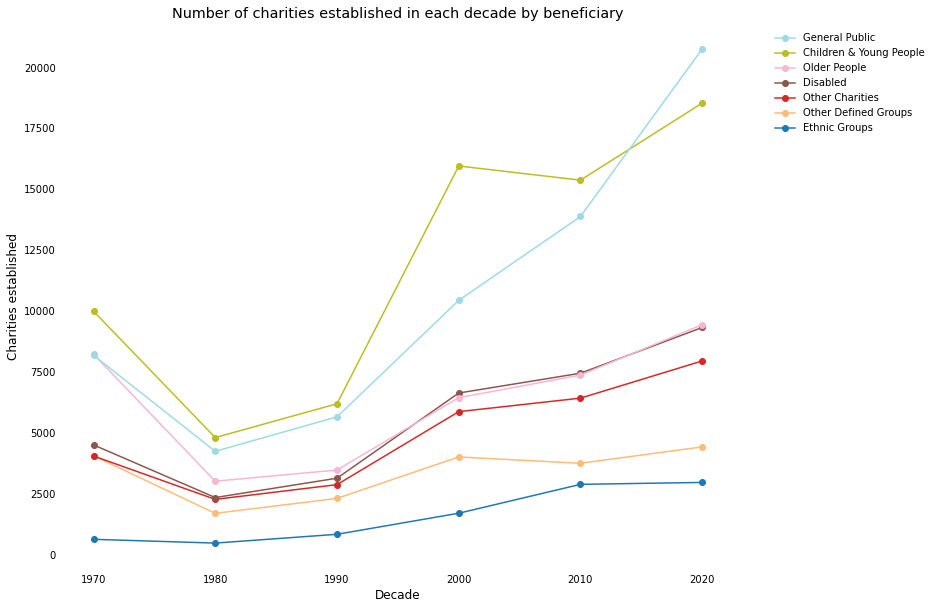

In [497]:
legends = ['General Public','Children & Young People', 'Older People', 'Disabled', 
           'Other Charities','Other Defined Groups','Ethnic Groups']
# plots the number of new charities created in each beneficiary group in each decade
ax = charity_decade_beneficiary_df.iloc[:-1,:].plot(figsize=(12,10), cmap='tab20', marker='o')
ax.axes.set_ylabel("Charities established", fontsize='large')
ax.axes.set_xlabel("Decade", fontsize='large')
ax.tick_params(bottom=False, left=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks(np.arange(0, 21500, step=2500))
ax.set_xticklabels(['1960','1970', '1980', '1990', '2000', '2010', '2020'])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], legends, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.set_title("Number of charities established in each decade by beneficiary", fontsize='x-large')
plt.savefig("charities_established_decade_beneficiary.png")

In [455]:
#This cell creates a new dataframe that counts the number of charities created in each decade offering each service
charity_decade_services_df = pd.DataFrame()
temp_df = pd.DataFrame()
for row in commission_codes.index[:10]: #iterates through the list of services
    #creates a name for the new column
    name = commission_codes.loc[row]['services_name']
    #creates the search term
    search = commission_codes.loc[row]['services_code']
    #puts the relevant charities into a temp frame where they match the current search code
    temp_df = charity_region_df[charity_region_df['charity_classification_uids'].str.contains(str(search))] 
    grouped = temp_df.groupby('decade').count() 
    grouped['services'] = name 
    charity_decade_services_df = charity_decade_services_df.append(grouped) 

#cleans up the dataframe to make it clearer for visualisation    
charity_decade_services_df.rename(columns={"year" : "new_charities"}, inplace=True)
charity_decade_services_df = charity_decade_services_df[['new_charities', 'services']]
charity_decade_services_df.reset_index(inplace=True)
charity_decade_services_df = charity_decade_services_df.pivot(index="decade", columns="services", values="new_charities")
charity_decade_services_df = charity_decade_services_df.sort_values(by=2010.0, axis=1)

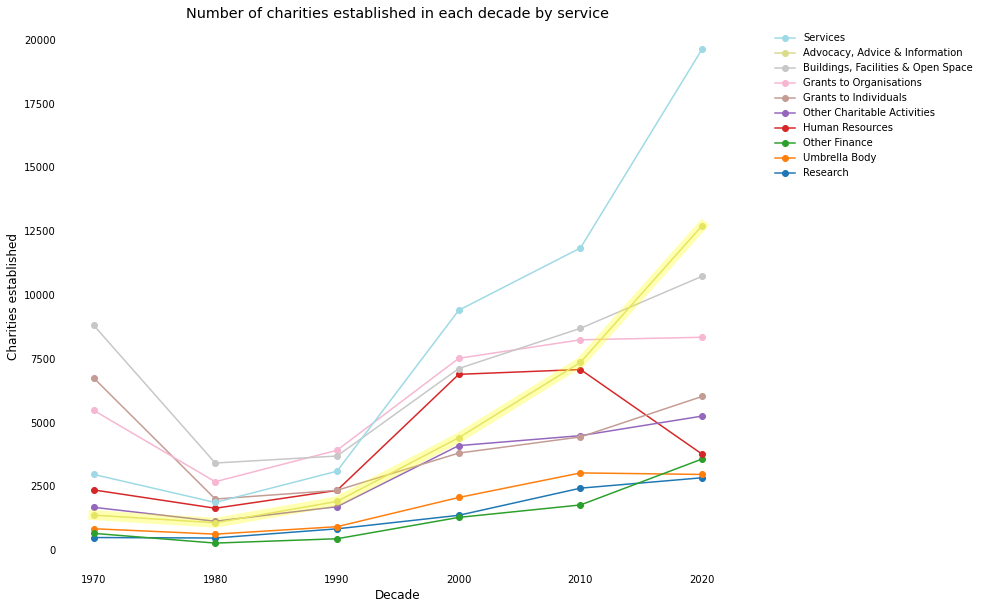

In [502]:
legends = ['Services', 'Advocacy, Advice & Information', 'Buildings, Facilities & Open Space',
           'Grants to Organisations','Grants to Individuals', 'Other Charitable Activities','Human Resources', 
           'Other Finance', 'Umbrella Body', 'Research']
# plots the number of new charities created in each services group in each decade
ax = charity_decade_services_df.iloc[:-1,:].plot(figsize=(12,10), cmap='tab20', marker='o')
plt.plot(charity_decade_services_df.iloc[:-1,8], color='Yellow', lw=10, alpha=0.3)
ax.axes.set_ylabel("Charities established", fontsize='large')
ax.axes.set_xlabel("Decade", fontsize='large')
ax.tick_params(bottom=False, left=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks(np.arange(0, 21500, step=2500))
ax.set_xticklabels(['1960','1970', '1980', '1990', '2000', '2010', '2020'])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], legends, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.set_title("Number of charities established in each decade by service", fontsize='x-large')
plt.savefig("charities_established_decade_services.png")

### Every part of the charity sector is growing

With few exceptions every sector, beneficiary and service group has increased its rate of growth since the 1970s. The largest groups have tended to get larger at a faster rate. There are a few exceptions such as the increased growth of charities in the recreation sector and those providing advocacy (both of which are highlighted on their respective charts). 

Overall, the picture is of a charitable sector where the larger groups continue to grow fastest and the less well represented groups like those focused on animals, helping specific ethnic groups, or performing research have grown much slower and now make up a much smaller part of the sector than they have in previous decades.